# Introduction

Equations are adapted from Russek et al. 2017 and Momennejad 2020. These papers, like Sutton & Barto, express successor states as $s_{t+1}$ or $s_{t'}$ (i.e., t-prime). Here, equations instead adopt the perspective of the agent, who subjectively experiences a current state $s_t$ and "remembers" the previous state $s_{t-1}$. The successor state is therefore expressed as $s_t$.

Code is adapted from Ida Momennejad's GitHub repository on [predictive representations](https://github.com/idamomen/predictive_representations).

Russek, E. M., Momennejad, I., Botvinick, M. M., Gershman, S. J., & Daw, N. D. (2017). Predictive representations can link model-based reinforcement learning to model-free mechanisms. PLOS Computational Biology, 13(9), e1005768. doi:10.1371/journal.pcbi.1005768

Momennejad, I. (2020). Learning Structures: Predictive Representations, Replay, and Generalization. Current Opinion in Behavioral Sciences, 32, 155-166. doi:10.1016/j.cobeha.2020.02.017

In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns

# The Successor Representation

Given that an agent starts out in state $X$, how often can it expect to end up in state $Y$? This is the kind of question addressed by the Successor Representation (SR), which can be learned through experience using standard temporal difference (TD) methods in the reinforcement learning (RL) framework.

As usual, the RL problem could be tackled as a prediction problem (learning the value of states), or a control problem (learning the value of actions).

## The SR matrix

If we're solving the prediction problem, this requires us to generate an $s \times s$ matrix, where $s$ is the number of states, rows indicate starting out in $X$, and columns indicate a potential future state $Y$.

If we're solving the control problem, this requires us to generate an $s \times sa$ matrix, where $a$ is the number of actions available at each state. For simplicity, this implementation assumes that the same actions are permissible in every state, though this is not a strictly necessary assumption to make.

In [2]:
def init_sr(n_states, n_actions=None):
    """
    Initialize a fresh set of matrices for learning the Successor Representation.
        Arguments:
            n_states:
                Number of states in the environment
            n_actions (optional):
                Number of actions that can be taken in each state
        Returns:
            successor_matrix:
                Starting in state X, how often can I expect to end up in state Y?
    """
    
    if n_actions is None:
        # Build successor matrix for learning counts in states
        successor_matrix = np.zeros((n_states, n_states))
        weight_vector = np.zeros(n_states)
    else:
        # Build successor matrix for learning counts in state-action pairs
        successor_matrix = np.zeros((n_states, n_states * n_actions))
        weight_vector = np.zeros(n_states * n_actions)  # this might not be right, check this later

    return successor_matrix, weight_vector

## SR update rule

Once a state transition has occurred, how do we update the SR matrix using TD learning?

For reference, the standard TD value-learning update rule is:

$ V(s_{t-1}) \leftarrow V(s_{t-1}) + \alpha [r_{t} + \gamma V(s_{t}) - V(s_{t-1})]$

&nbsp;

In the SR matrix, we are interested in counts, not values. So we can simply replace the value terms with counts:

$ M(s_{t-1}) \leftarrow M(s_{t-1}) + \alpha [\boldsymbol{1}(s_t) + \gamma M(s_t) - M(s_{t-1})]$,

where $\boldsymbol{1}$ is a function producing a vector of $0$s except for a single $1$ at the index $s_t$ (aka, a *one-hot* vector).

&nbsp;

As usual, the RL problem can either be tackled as a prediction problem (learning the value of states), or a control problem (learning the value of actions). The above formulations are for learning state counts only. We can extend this into the Q-learning framework so that we can instead learn counts for actions *within* states:

$ H(s_{t-1}a_{t-1}) \leftarrow H(s_{t-1} a_{t-1}) + \alpha [\boldsymbol{1}(s_t a_t) + \gamma H(s_t a_t) - H(s_{t-1} a_{t-1})] $

&nbsp;

We relaxed the notation a little bit for simplicity, and to emphasize the similarity with the standard value-learning update rule. In reality, the matrix $M$ is constructed *for a particular policy* $\pi$ and should technically be written as $M^{\pi}$. Additionally, in implementation, *an entire row* of the SR gets replaced, as shown here:

$ M^{\pi}(s_{t-1}, \space :) \leftarrow M^{\pi}(s_{t-1}, \space :) + \alpha [\boldsymbol{1}(s_t) + \gamma M^{\pi}(s_t, \space :) - M^{\pi}(s_{t-1}, \space :)]$

$ H(s_{t-1}a_{t-1}, \space :) \leftarrow H(s_{t-1} a_{t-1}, \space :) + \alpha [\boldsymbol{1}(s_t a_t) + \gamma H(s_t a_t, \space :) - H(s_{t-1} a_{t-1}, \space :)] $

In [3]:
def update_sr(sr_matrix, agent_params, agent_location):
    """
    Given a transition from state X to state Y, update the SR with the latest count of expected visits to Y (and its successors) from X.
        Arguments:
            sr_matrix:
                The most recent SR matrix. Expects a numpy *float!* array.
            agent_params:
                Tuple of free parameters dictating the agent's learning.
                    [0] = alpha (learning rate)
                    [2] = gamma (temporal discounting)
            agent_location:
                Tuple of the agent's current and previous 'location' occupancy.
                    [0] = previous state / state-action pair
                    [1] = current state / state-action pair
        Returns:
            sr_matrix
    """

    # For ease of reading code
    alpha = agent_params[0]
    gamma = agent_params[2]
    loc_prev = agent_location[0]
    loc_now = agent_location[1]
    
    # Create the one-hot (row) vector that signals what the current state is
    this_onehot = np.zeros(np.shape(sr_matrix)[0])
    this_onehot[loc_now] = 1

    # Compute the temporal difference prediction error
    delta = this_onehot + (gamma * sr_matrix[loc_now, :]) - sr_matrix[loc_prev, :]

    # Now update the SR matrix
    sr_matrix[loc_prev, :] = sr_matrix[loc_prev, :] + (alpha * delta)
    
    # Return updated SR matrix
    return sr_matrix

# Value-learning

For the purpose of estimating the value of states, it's not sufficent to represent the environment's structure (well, more accurately, expectations about future state occupancies). You must also know where to find rewards, and must integrate this reward knowledge into your knowledge about the environment.

## Function approximation and generalization

The major limitation of standard RL is that an optimal policy can only be found if an agent explores every part of the state space (as otherwise, it can't accurately estimate the value of all states in the environment). In complex environments, this is all but impossible. Moreover, we have the intuition that an agent should value states more similarly if the states are more similar to each other. Therefore, an agent needs to be able to *infer* the value of states even if it cannot directly visit them, and we believe that this inference process should incorporate information about states' similarity to each other. In other words, an agent must devise a way to *approximate* a given function (such as a value function), which allows it to make such inferences by generalizing its past experience. This is known, sensibly, as function approximation.

As per Sutton & Barto 1998, section 8.3, there's a fairly straightforward linear method for doing this. Imagine that every state can be described using some "features." For example, in the children's game "the floor is lava", the objective is to avoid touching the floor. The optimal strategy is therefore to hop through an environment on top of tables and chairs. A relevant feature for this environment might be knowing whether each state's elevation is higher than the elevation of the floor. This creates a binary feature variable, where $0 = \text{same elevation}$ and $1 = \text{greater elevation}$. Even if the entire state space is not explored (indeed, it'd be in one's best interests *not* to visit state spaces where the floor is lava), knowing the feature space is sufficient for generalization. We can represent feature information in a vector, where each element represents each state's value in feature space.

How do we then translate knowledge about features into an approximation of the value function? A different way to ask this question is to ask how to *weight* features so that we can estimate the value of unseen states. If this sounds like linear regression to you, then you're exactly right. The general form of a linear regression is $ \hat{Y} = \beta_1Predictor_1 + \beta_2Predictor_2 + ... + \beta_nPredictor_n $ (for exposition, intercept/error terms are omitted). In the exact same way, our feature vector $x$ is multiplied against a weighting vector $w$ to produce the value estimate $\hat{V}$. If there are $n$ features that are used to describe the value function, then we would have a linear sum of features in the general form $ \hat{V} = x_1 w_1 + x_2 w_2 + ... + x_n w_n $ for each state.

## Using the SR for function approximation

Dayan 1992 was the first to suggest that the standard TD value function can be reparameterized in this way, producing the equation:

$ V^\pi(s_{t-1}) = \sum_{s_t} M^\pi(s_{t-1}, s_t) \sum_a \pi(a|s_t) R(s_t, a) $

For conceptual clarity, this equation can be rewritten to emphasize that there are two distinct components:

$ V^\pi(s_{t-1}) = \sum_{s_t} M^\pi(s_{t-1}, s_t) w(s_t) $

We've already examined the SR component, expressed as $M^\pi(s_t, s_{t+1})$. This can be conceptualized as a feature matrix (where each row is a feature vector), such that each "feature" being encoded by the agent is an expectation of ending up in a given successor state starting from their current state.

If we've already defined a feature vector $M$, the second component we need is a weighting vector $w$. If we care about reward knowledge, that weighting vector needs to represent the expected reward in a successor state (given that many different actions could be taken, which might result in different amounts of reward). We can express this as the combination of knowledge about the one-step reward in successor state $s_t$ given some action that is taken $R(s_t, a)$, which is averaged over all possible actions that could be taken in the successor state. Therefore, we'd like $w = \sum_a \pi(a|s_t) R(s_t, a)$.

In this formulation, the SR is known as a "basis function" for the value function. It's a fancy way of saying that you can linearly combine the SR with other knowledge in order to produce the value function.

In [4]:
def compute_value(sr_matrix, weight_vector, state):
    """
    The values of states X and Y are not stored in the usual state-value matrix, but must be computed by combining the SR matrix and weight vector.
        Arguments:
            sr_matrix:
                The most recent SR matrix. Expects a numpy *float!* array.
            weight_vector:
                The most recent weight vector. Expects a 1-D numpy array.
            state:
                A state / state-action pair. Scalar.
            
        Returns:
            value_state
    """
    
    value_state = np.inner(sr_matrix[state, :], weight_vector)

    return value_state

## Learning weights through experience

Weights can be estimated from experience through standard TD learning:

$ w_{new}(:) \leftarrow w_{old}(:) + \alpha \delta M^\pi(s_{t-1}, :) $

where $\alpha$ is a learning rate, $M$ is the SR matrix, and the prediction error is $ \delta = R(s_{t-1}, a) + \gamma V(s_t) - V(s_{t-1}) $.

## Scaling (optional read)

In implementation, when we pull out a particular row of the SR matrix to update $w$ (i.e., the feature vector corresponding to the transition from $s_{t-1}$ to $s_t$), we'll want to use a *scaled* version of $M$. Why is this? (Much of this section is either adapted or outright lifted from personal correspondence with Evan Russek, who very kindly walked me through the logic.)

In the standard TD update equation, we want our learning rate $\alpha$ to reflect what proportion of a predictor error is used for value updating. This looks like:  
$ \Delta V = V(s_t) - V(s_{t-1}) $

We want updates in $w$ to have the same proportional effect on value updating as $\alpha$, so we can use scaling as a "trick" for doing this. But what would happen if we didn't use scaling? Recall that value can be computed by taking the dot product of the relevant SR row and the reward vector, which makes the value equation:  
$ \Delta V = M(s_t)w_{new} - M(s_t)w_{old} $

This can be algebraically rearranged as:  
$ \Delta V = M(s_t) [w_{new} - w_{old}] $

We then replace $w_{new}$ from the weight-learning update equation:  
$ \Delta V = M(s_t) [w_{old} + \alpha \delta M(s_{t-1}) - w_{old}] $

This simplifies to:  
$ \Delta V = M(s_t) [\alpha \delta M(s_{t-1})] $

And to really drive home the point, we can rearrange the terms:  
$ \Delta V = \alpha \delta M(s_t) M(s_{t-1}) $

So we see there's a problem here, which is that the proportional update from $\delta$ to $\Delta V$ is not really dictated by $\alpha$, but rather by $ \alpha M(s_t) M(s_{t-1}) $. This completely messes with our weights, and functionally prevents the SR agent from ever converging upon a stable value estimate.

To solve this, we can (temporarily!) scale $M(s_{t-1})$ in the following way:  
$ M(s_{t-1})_{scaled} \leftarrow M(s_{t-1}) \space \oslash \space \sum  M(s_{t-1}) M(s_{t-1}) $,  
where $\oslash$ denotes element-wise division (Hadamard division).

If all this notation looks like chickenscratch, here's a more intuitive description of what scaling does. First, find the sum-of-squares of the SR row you're interested in. Then, divide each element of the SR row by that sum-of-squares. That takes us from $ M(s_t) M(s_{t-1}) \alpha \delta $ to $ M(s_t) M(s_{t-1}) \alpha \delta $

In [5]:
def update_weights(sr_matrix, agent_params, agent_location, weight_vector, reward):
    """
    Given a transition from state X to state Y, and the associated reward, update the weight matrix so that the SR can be mapped to the value function.
        Arguments:
            sr_matrix:
                The most recent SR matrix. Expects a numpy *float!* array.
            agent_params:
                Tuple of free parameters dictating the agent's learning.
                    [0] = alpha (learning rate)
                    [2] = gamma (temporal discounting)
                        In principle, the agent could have a different alpha/gamma for updating weights vs the SR.
                        But, for simplicity, we assume that they're the same.
            agent_location:
                Tuple of the agent's current and previous 'location' occupancy.
                    [0] = previous state / state-action pair
                    [1] = current state / state-action pair
            weight_vector:
                The most recent weight vector. Expects a 1-D numpy array.
            reward:
                Scalar reflecting the amount of reward observed when transitioning from X to Y.
        Returns:
            weight_vector
    """

    # For ease of reading code
    alpha = agent_params[0]
    gamma = agent_params[2]
    loc_prev = agent_location[0]
    loc_now = agent_location[1]

    # Compute state values
    value_loc_prev = compute_value(sr_matrix, weight_vector, loc_prev)
    value_loc_now = compute_value(sr_matrix, weight_vector, loc_now)
    
    # Compute prediction error
    delta = reward + (gamma * value_loc_now) - value_loc_prev

    # Compute feature-scaled SR
    scaled_sr = sr_matrix[loc_prev, :] / np.sum(np.square(sr_matrix[loc_prev, :]))

    # Use prediction error to update the weight vector
    weight_vector = weight_vector + (alpha * delta * scaled_sr)

    return weight_vector

# Replay (SR-Dyna)

If an agent is only capable of learning from direct experience, it would require a *lot* of trial-and-error to form a stable/accurate estimate of state/action values. What if an agent were additionally able to *simulate* experience, and to learn from that simulated experience? This is the key idea behind the Dyna-RL architecture, developed by Sutton & Barto. Interestingly, there is evidence that the brain "replays" experience to aid in memory consolidation.

## Recency mechanism

Which events should be "selected" for replay? One simple solution is to sample from past experience, with a bias for sampling the most recently-experienced transitions. This is conceptually similar to the eligibility trace method, except that eligibility traces operate directly on state/action value estimates during "online" direct experience. Instead, we'll give the agent a memory system that stores a history of what transitions it has recently experienced, which is only tapped when performing "offline" updates to the SR matrix.

There are different ways that a recency mechanism could be implemented. In past published work, Ida Momennejad and colleagues have favored an exponentially weighted function where the last $n$ transitions are ordered from $[0:n-1]$, divided by $25$ (to help compress the range), and then exponentiated using Euler's number $e$ as the base. That vector is normalized so that it sums to $1$, and that represents a vector of probabilities that a particular transition will be replayed.

Here, I (loosely!) draw inspiration from eligibility traces. The memory system maintains a record of all transitions that have been experienced, but gradually forgets about the older experiences depending on the free parameter $\lambda \in [0, 1]$. When $\lambda = 0$, the agent is only able to remember/replay the transition it has *just* experienced (i.e., from $s_{t-1}$ to $s_t$). When $\lambda = 1$, the agent remembers a perfect record of every transition it has ever experienced, and the probability of a given transition being replayed is directly proportional to the number of times that transition has ever been experienced. In practice, this is pretty much the same mechanism as Momennejad et al., except that the exponential decay of "memory traces" is dictated by a free parameter.

## Prioritized sweeping

The brain does not seem to randomly "select" events to replay, but rather prioritizes events that were especially surprising (along with those events' predecessor states). This is reminiscent of the "prioritized sweeping" mechanism within the Dyna architecture, in which backups propogate according to how much the backup (if performed) would change the state/action value under "consideration." In practice, this method assigns prediction errors to a "priority queue" based on the PE magnitude. During replay, events are sequentially used to update the value estimate according to their priority in the queue. Then, for all states/actions that are predicted to lead to that event... (hm, looks like there's a model that's explicitly needed, see p240 of S&B 1e. for now, leave this alone. return to it later if you must.)

In [ ]:
def replay_recency

In [39]:
for i in np.arange(10):
    print('{} to {}'.format(i, np.exp(i/25)))

np.arange(10)

0 to 1.0
1 to 1.0408107741923882
2 to 1.0832870676749586
3 to 1.1274968515793757
4 to 1.1735108709918103
5 to 1.2214027581601699
6 to 1.2712491503214047
7 to 1.3231298123374369
8 to 1.3771277643359572
9 to 1.4333294145603401


In [43]:
y=[]
for i in range(len(np.arange(5))):
    y.append(np.exp(i/25)) # division: more chance to smaller numbers, avoids range error
norm_p_weights = [float(i)/sum(y) for i in y]

print(y)
print(norm_p_weights)
print(np.sum(norm_p_weights))

[1.0, 1.0408107741923882, 1.0832870676749586, 1.1274968515793757, 1.1735108709918103]
[0.18432821041400219, 0.19185078738649505, 0.19968036654915722, 0.20782947689904818, 0.2163111587512974]
1.0


# The SR in action

## Description of learning problem

Now that we've built all of the fundamental components of the vanilla SR agent, we can demo how it works in a very simple learning task. This is a simulation of Momennejad et al., 2017, experiment 1.

Imagine that you're hungry, and that you want to go buy some lunch. You know that there are two restaurants, one to the left (three blocks away), and one to the right (also three blocks away). For some inexplicable reason, you always flip a coin when deciding which direction to go. As a learning agent, you want to learn a stable estimate of each state in your environment. How many lunches does it take before you learn a stable estimate?

Momennejad, I., Russek, E. M., Cheong, J. H., Botvinick, M. M., Daw, N. D., & Gershman, S. J. (2017). The successor representation in human reinforcement learning. Nature Human Behaviour. doi:10.1038/s41562-017-0180-8

## Implementing the environment

In most RL implementations, state spaces are discrete, not continuous. For this reason, we'll use network graphs to simplify the problem of having to construct/navigate state spaces. We'll use the package `igraph` for this purpose. Even gridworld environments are well-described by graphs (though we don't typically think of them as such), making graphs a scalable/flexible foundation for constructing environments of arbitrary complexity.

In [6]:
def get_edge_attrib(which_graph, which_attrib, source, target):
    """
    Find the edge between two nodes, then pull out an edge attribute of interest.
        Arguments:
            which_graph: igraph object
            which_attrib: string corresponding to an edge attribute
            source: source node
            target: target node
        Returns:
            attrib: the attribute of interest
    """
    attrib = which_graph.es.select(_between = ([source], [target]))[which_attrib][0]
    return attrib

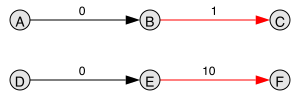

In [9]:
# Environment from Momennejad et al 2017, experiment 1
momen_edgelist = pd.DataFrame(
    [['A', 'B', 0, 0],
    ['B', 'C', 1, 1],
    ['D', 'E', 0, 0],
    ['E', 'F', 10, 1]],
    columns = ['source', 'target', 'reward', 'terminal_state']
)

momen_nodelist = pd.DataFrame(
    [['A', 1],
    ['B', 0],
    ['C', 0],
    ['D', 1],
    ['E', 0],
    ['F', 0]],
    columns = ['name', 'start_state']
)

terminal_colors = {
    1: 'red',
    0: 'black'
}

momen_g = ig.Graph.DataFrame(
    edges = momen_edgelist,
    vertices = momen_nodelist,
    directed = True
    )

ig.plot(
    momen_g,
    bbox = (300, 100),
    layout = momen_g.layout_grid(),
    vertex_label = momen_g.vs['name'],
    vertex_color = 'grey90',
    edge_color = [terminal_colors[node] for node in momen_g.es['terminal_state']],
    edge_label = momen_g.es['reward']
    )

In [ ]:
def run_sr_passive(env, agent_params, replay=False, run_params=(0.001, np.Inf)):
    """
    Runs a passive (no action) Successor Representation agent through an environment.
        Arguments:
            env: igraph Graph object
                Edge attributes must include 'reward' (scalar) and 'terminal_state' (0/1 indicators)
                Node attributes must include 'name' (scalar or string) and 'start_state' (0/1 indicators)
            agent_params: numeric tuple
                [0]: alpha
                [1]: beta (unused)
                [2]: gamma
            replay: Boolean
            run_params: tuple
                [0]: maximum change in value estimate before concluding convergence
                [1]: maximum number of episodes before giving up
        Returns:
            x
    """

    ### Initialize
    # Unpack agent prefs
    alpha = agent_params[0]
    beta = agent_params[1]
    gamma = agent_params[2]

    # Unpack runtime parameters
    if run_params == None:
        value_convergence_threshold = 0.001
        max_episodes = 10000
    else:
        value_convergence_threshold = run_params[0]
        max_episodes = run_params[1]

    # SR matrix and weight vector
    sr_matrix, weight_vector = init_sr(n_states = env.vcount())
    
    # Episodes / convergence info
    n_episodes = 0
    value_last_episode = np.zeros(env.vcount())

    # List of valid starting state(s)
    starting_states = [v.index for v in env.vs(start_state = 1)]

    ### Run agent through experiment
    # Repeat episodes until convergence
    while True:
        # Choose a starting state
        state_now = int(np.random.choice(starting_states, size = 1))

        # Move through states until terminal state is reached
        while True:
            # Pick a successor state randomly
            successors = env.successors(state_now)
            state_prev = state_now
            state_now = int(np.random.choice(successors, size = 1))
            reward = get_edge_attrib(env, 'reward', state_prev, state_now)

            # Update SR and weights
            agent_state = (state_prev, state_now)
            sr_matrix = update_sr(sr_matrix, agent_params, agent_state)
            weight_vector = update_weights(sr_matrix, agent_params, agent_state, weight_vector, reward)

            # Have we reached a terminal state?
            if get_edge_attrib(env, 'terminal_state', state_prev, state_now):
                break
        
        # Update the number of episodes that have elapsed
        n_episodes += 1

        # Check convergence
        value_this_episode = np.inner(ida_exp1_sr, ida_exp1_weights)
        biggest_value_diff = np.max(np.abs(np.subtract(value_this_episode, value_last_episode)))
        if biggest_value_diff < value_convergence_threshold:
            print('Converged after {} episodes'.format(n_episodes))
            break
        if n_episodes == max_episodes:
            print('Convergence failed after {} episodes'.format(n_episodes))
            break
        else:
            value_last_episode = value_this_episode.copy()
    
    return sr_matrix, weight_vector, n_episodes

In [30]:
#print(momen_g)
test = [v.index for v in momen_g.vs(start_state = 1)]

#print(test)
#test.index[0].index()

In [ ]:
def run_sr_active(env_g, agent_params, replay=False, run_params=(0.001, np.Inf)):
    ### Unpack arguments
    alpha = agent_params[0]
    beta = agent_params[1]
    gamma = agent_params[2]
    # maybe add epsilon for e-greedy, idk

    active_action = agent_architecture[0]
    replay = agent_architecture[1]

    value_convergence_threshold = run_params[0]
    max_episodes = run_params[1]

    ### Initialize
    

In [8]:
# Initialize the SR matrix and weight vector
ida_exp1_sr, ida_exp1_weights = init_sr(n_states = g_ida_exp1.vcount())

# Initialize agent free parameters
#   (alpha, beta, gamma)
agent_prefs = (0.1, 0.5, 0.6)

# Initialize convergence information
value_convergence_threshold = 0.001
n_episodes = 0
value_last_episode = np.zeros(g_ida_exp1.vcount())

# Repeat episodes until convergence
while True:
    # Randomly choose a starting state
    state_now = int(np.random.choice((0, 3), size = 1))

    # Move through states until terminal state is reached
    while True:
        # Pick a successor state
        successors = g_ida_exp1.successors(state_now)
        state_prev = state_now
        state_now = int(np.random.choice(successors, size = 1))
        reward = get_edge_attrib(g_ida_exp1, 'reward', state_prev, state_now)

        # Update SR and weights
        agent_state = [state_prev, state_now]
        ida_exp1_sr = update_sr(ida_exp1_sr, agent_prefs, agent_state)
        ida_exp1_weights = update_weights(ida_exp1_sr, agent_prefs, agent_state, ida_exp1_weights, reward)

        # Have we reached a terminal state?
        if get_edge_attrib(g_ida_exp1, 'terminal_state', state_prev, state_now):
            break
    
    # Update the number of episodes that have elapsed
    n_episodes += 1

    # Check convergence
    value_this_episode = np.inner(ida_exp1_sr, ida_exp1_weights)
    biggest_value_diff = np.max(np.abs(np.subtract(value_this_episode, value_last_episode)))
    if biggest_value_diff < value_convergence_threshold:
        break
    else:
        value_last_episode = value_this_episode.copy()

# Plot results
plot_sr, ax_sr = plt.subplots(1)
sns.heatmap(ida_exp1_sr, annot=True, square=True, cmap="YlGnBu", ax=ax_sr).set_title('Converged SR matrix')

plot_reward, ax_reward = plt.subplots(1)
sns.heatmap(ida_exp1_weights[np.newaxis, :], annot=True, cmap="YlGnBu", ax=ax_reward).set_title('Converged (reward) weight vector')

NameError: name 'g_ida_exp1' is not defined

In [ ]:
sns.heatmap(ida_exp1_sr, annot=True, square=True, cmap="YlGnBu")

In [ ]:
sns.heatmap(ida_exp1_weights[np.newaxis, :], annot=True, cmap="YlGnBu")

# sandbox

In [32]:
test = 5
print('Convergence failed after {} attempts'.format(test))

Convergence failed after 5 attempts
